# Facial emotion recogition model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import the required Libraries

In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import visualkeras

### FER-2013 Dataset Analysis

In [3]:
dataset_path = "/content/drive/MyDrive/data"
# List the contents of the dataset directory
print(os.listdir(dataset_path))

['test', 'train']


In [4]:
# create the path for dataset directories
train_data_dir = '/content/drive/MyDrive/data/train'
test_data_dir = '/content/drive/MyDrive/data/test'

In [5]:
# List the different emotions of the FER2013 dataset
train_expressions = os.listdir(train_data_dir)
test_expressions = os.listdir(test_data_dir)

print("Emotion Categories in Train set:", train_expressions)
print("Emotion Categories in Test set:", test_expressions)

Emotion Categories in Train set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Emotion Categories in Test set: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
# Dictionaries to store the image counts
train_image_counts = {expr: 0 for expr in train_expressions}
test_image_counts = {expr: 0 for expr in test_expressions}

# Count the number of images for each emotion category
for expr in train_expressions:
    train_image_counts[expr] = len(os.listdir(os.path.join(train_data_dir, expr)))

for expr in test_expressions:
    test_image_counts[expr] = len(os.listdir(os.path.join(test_data_dir, expr)))

# Calculate the total number of images in the training and testing sets
total_train_images = sum(train_image_counts.values())
total_test_images = sum(test_image_counts.values())

# Print the counts of the images in the sets
print("\nNumber of images per emotion category in the Train Set:")
for expr, count in train_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Train set Images: {total_train_images}")

print("\nNumber of images per emotion category in the Test Set:")
for expr, count in test_image_counts.items():
    print(f"{expr}: {count}")
print(f"Total Test set Images: {total_test_images}")


Number of images per emotion category in the Train Set:
angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171
Total Train set Images: 28709

Number of images per emotion category in the Test Set:
angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831
Total Test set Images: 7178


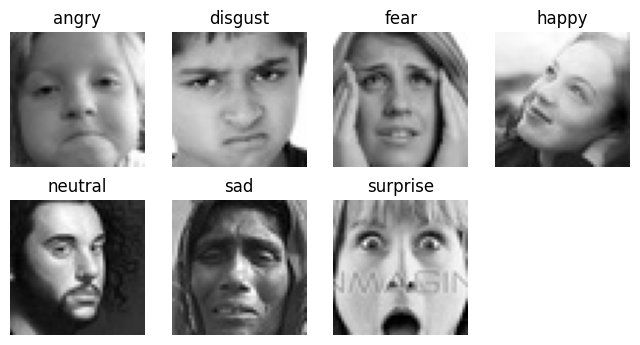

In [12]:
# visualize the images from the dataset
emotions = os.listdir(train_data_dir)
plt.figure(figsize=(8, 4))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_data_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[33])

    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

plt.show()

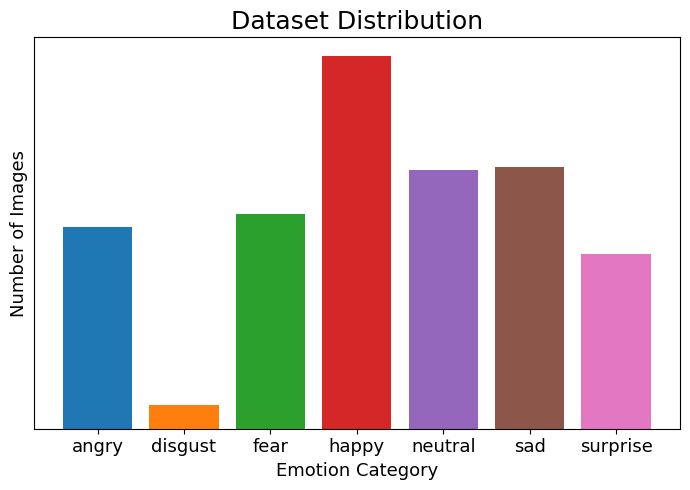

In [14]:
# Plot the dataset distribution as a graph
plt.figure(figsize=(7, 5))
colors=sns.color_palette("tab10")
plt.bar(test_image_counts.keys(), test_image_counts.values(), color=colors)
plt.title("Dataset Distribution", fontsize=18)
plt.xlabel("Emotion Category", fontsize=13)
plt.ylabel("Number of Images", fontsize=13)
plt.xticks(rotation=0, fontsize=13)
plt.yticks([])
plt.tight_layout()
plt.show()

### Data preparation

In [16]:
# Specify the target size for images
img_size = 48
# Set the batch size
batch_size = 64

In [17]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Define the preprocessing parameters for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale = 1./ 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    color_mode='grayscale',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Creating the model

In [ ]:
# https://www.tensorflow.org/guide/keras/sequential_model
model = Sequential()
model.add(Input(shape=(img_size, img_size, 1)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

#### Model summary

In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

#### Defining callbacks

In [ ]:
# https://keras.io/api/callbacks/
# define callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor validation loss
    factor=0.5,             # Reduce LR by 0.5
    patience=5,             # Wait 5 epochs with no improvement before reducing LR
    min_lr=1e-5,            # Minimum LR value
    verbose=1               # Display messages when learning rate is reduced
)

early_stopping = EarlyStopping(
    monitor="val_loss",        # Monitor validation loss
    patience=10,               # Stop after 10 epochs with no improvement
    verbose=1,                 # Display message when training is stopped
    restore_best_weights=True, # Restore best model weights
    min_delta=0.0001           # Consider significant changes
)

callbacks = [reduce_lr, early_stopping]

#### Model training

In [ ]:
# https://www.tensorflow.org/guide/keras/training_with_built_in_methods
# Train the model
epochs = 80
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks = callbacks,
    verbose=1

)

# Save the model
model.save('/content/drive/MyDrive/new_model.h5')

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.2298 - loss: 2.3050 - val_accuracy: 0.1843 - val_loss: 1.9591 - learning_rate: 0.0010
Epoch 2/80
359/359 ━━━━━━━━━━━━━━━━━━━━ 34s 93ms/step - accuracy: 0.3189 - loss: 1.7927 - val_accuracy: 0.3606 - val_loss: 1.6135 - learning_rate: 0.0010
Epoch 3/80
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.4215 - loss: 1.5056 - val_accuracy: 0.4539 - val_loss: 1.4175 - learning_rate: 0.0010
Epoch 4/80
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 96ms/step - accuracy: 0.4809 - loss: 1.3522 - val_accuracy: 0.4349 - val_loss: 1.5422 - learning_rate: 0.0010
Epoch 5/80
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.5110 - loss: 1.2785 - val_accuracy: 0.4748 - val_loss: 1.3711 - learning_rate: 0.0010
Epoch 6/80
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.5333 - loss: 1.2276 - val_accuracy: 0.4750 - val_loss: 1.3948 - learning_rate: 0.0010
Epoch 7/80
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.5402 - loss: 1.202

### Results and Evaluation
##### 1. Accuracy

In [ ]:
# Evaluation of the model on the sets
train_loss,train_acc=model.evaluate(train_generator)
val_loss,val_acc=model.evaluate(validation_generator)
test_loss, test_acc = model.evaluate(test_generator)
print("Training Accuracy:{:.2f}%".format(train_acc*100))
print("Validation Accuracy:{:.2f}%".format(val_acc*100))
print("Test Accuracy:{:.2f}%".format(test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.7823 - loss: 0.5973
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6038 - loss: 1.1307
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.6311 - loss: 1.0654
Training Accuracy:77.89%
Validation Accuracy:66.43%
Test Accuracy:67.75%


#### 2. Accuracy and Loss graphs

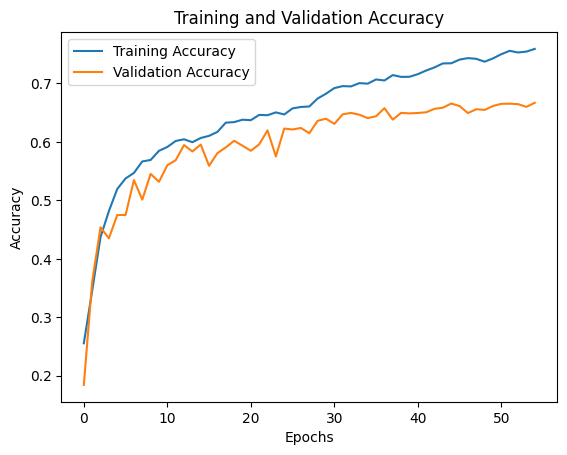

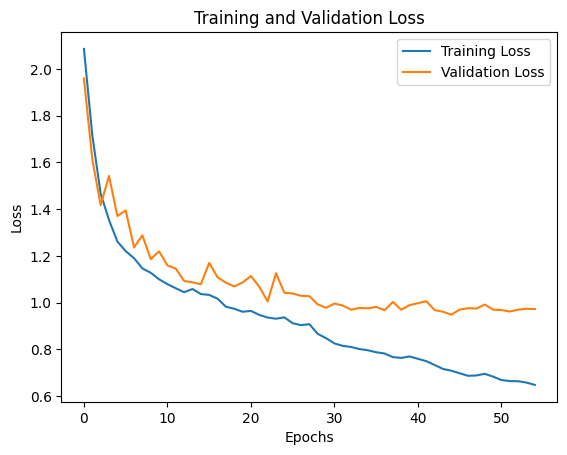

In [ ]:
# Plot the graphs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 3. Classification Report

In [ ]:
# Load the trained model
model = load_model("/content/drive/MyDrive/new_model.h5")

# Load test data, class names and the true labels
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Get predictions
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.60      0.61       958
     disgust       0.75      0.45      0.56       111
        fear       0.58      0.42      0.48      1024
       happy       0.86      0.89      0.87      1774
     neutral       0.58      0.70      0.64      1233
         sad       0.55      0.59      0.57      1247
    surprise       0.79      0.76      0.78       831

    accuracy                           0.68      7178
   macro avg       0.68      0.63      0.64      7178
weighted avg       0.68      0.68      0.67      7178



#### 4. a. Confusion Matrix A

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step


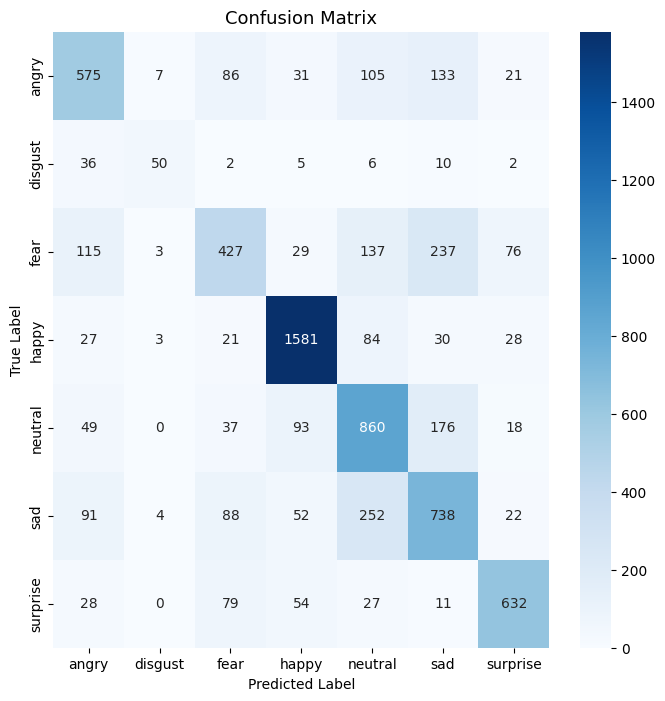

In [ ]:
#Load the trained model and evaluate it when the shuffle is set to False in the test generator
#Load the trained model
model = load_model("/content/drive/MyDrive/new_model.h5")

# Get the true labels from the test generator
y_true = test_generator.classes
# Class names
labels = list(test_generator.class_indices.keys())

# Get predictions
y_pred = model.predict(test_generator)
# Convert to class labels
y_pred = np.argmax(y_pred, axis=1)
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 8))

sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix",fontsize=13)
plt.show()

### Model Structure

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


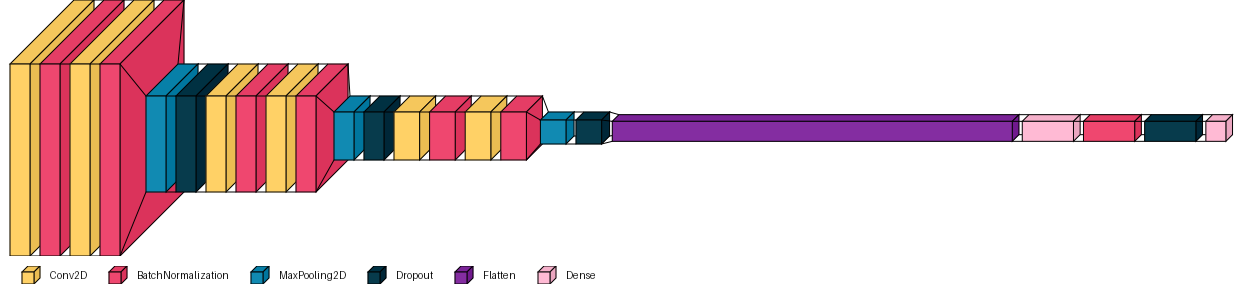

In [20]:
# Load the model
model = load_model("/content/drive/MyDrive/new_model.h5")

# Visualize the model
visualkeras.layered_view(model, legend=True, draw_volume=True)

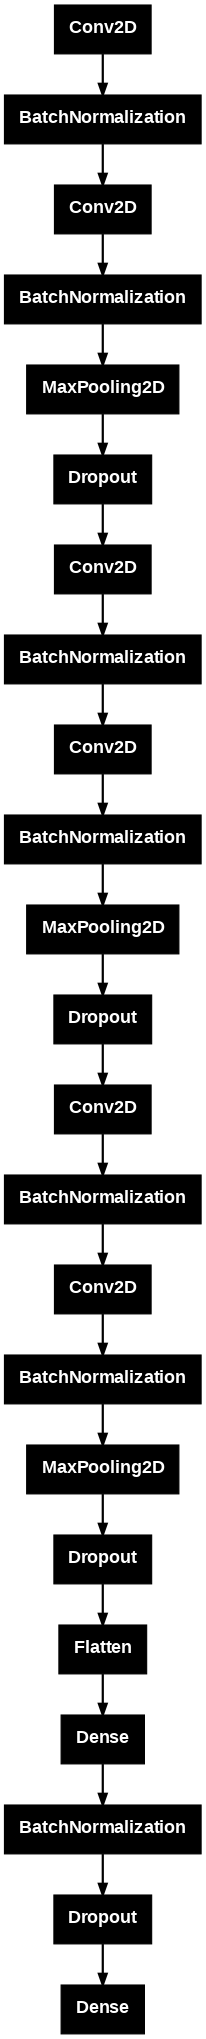

In [ ]:
# Model structure
plot_model(model, to_file="model.png", show_shapes=False, show_layer_names=False, dpi=80)